In [1]:
# Compiled from the previous works :
# https://github.com/genzellab/HM_RAT/blob/main/SYNCHRONIZATION/synch_editedbyOzge.py
# https://github.com/genzellab/HM_RAT/blob/main/SYNCHRONIZATION/Exctract_LEDs_28_01_2023.ipynb
# https://github.com/genzellab/HM_RAT/blob/main/SYNCHRONIZATION/synchronization.py

# Author: Param Rajpura
# 28th May 2023


%matplotlib notebook
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm, tnrange
from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans
import pandas as pd
from scipy.signal import find_peaks,peak_prominences
from datetime import datetime , time , timedelta
import re
import functools as ft
from sklearn.linear_model import LinearRegression

# Extract file paths from the user defined basepath 

In [2]:
 '''
 The basepath must contain the following files:
 1. Eye video files: .mp4 formats (12 files for each eye)
 2. X,y co-ordinates of crops for LED positions : .led_crop format (1 file containing 12 xy co-ordinates)
 3. Time stamp files containing framewise clock timestamps after linear regression: .csv format (12 files)
 4. Time stamps recorded from LED controller referred to as DIO: .dat format (3 files for red,blue and 
 initial systime)
 '''


# Reads all the mp4 files in the folder, checks for a led_crop_coordinates file and meta file
def get_video_files_with_metadata(basepath,led_xy=True,time_stamp=True):
    path = Path(basepath).resolve()
    videos_filepath_list = list(sorted(path.glob('*.mp4')))
#     print(videos_filepath_list)
    
    crop_xy_dict = {}
    # Verify if led_coordinates supplied
    if led_xy:
        crop_file_list = list(sorted(path.glob('*.led_crop')))
#         print(crop_file_list)
        if crop_file_list:
            # read crops coords for each video and store
            with open(crop_file_list[0]) as f:
                crop_txt = f.readlines()
#                 print(crop_txt)
            for line in tqdm(crop_txt):
                try:
                    vid_path, x, y = line.split(',')
                    crop_xy_dict[vid_path] = (int(x), int(y))
                except ValueError:
                    print("Faulty line:", line, 'Maybe led coordinates are missing?')
                    break
        else:
            raise Exception("File containing led crop coordinates not found.")
    if time_stamp:
        tsdata_filepath_list = list(sorted(path.glob('*.csv')))
        
    #TODO: Verify for single file path in the list to avoid conflicting data
    dio_file_path_dict={}
    dio_file_path_dict['init'] = list(sorted(path.glob('*maze.*.dat')))
    
    dio_file_path_dict['blue'] = list(sorted(path.glob('*maze_merged*Din1.dat')))
    dio_file_path_dict['red'] = list(sorted(path.glob('*maze_merged*Din2.dat')))
    return videos_filepath_list,crop_xy_dict,tsdata_filepath_list,dio_file_path_dict


# Functions to extract LED signals from video data 

In [3]:
def process_ica_signals(demixed, mix_weights,time_meta):
    fps = 30.0
    eD = 0.5       # expected Duty cycle of 0.5
    ef_red = 0.5   # expected frequency of 0.5 Hz
    ef_blue = 2.5  # expected frequency of 2.5 Hz
    
    dD = np.zeros(demixed.shape[1])
    df_red = np.zeros(demixed.shape[1])
    df_blue = np.zeros(demixed.shape[1])
    
    colors = {0: 'red', 1: 'blue', None: 'gray'}
    N = -1
    N_ICA = -1  # numbers of samples to use for ICA, -1 for all
    
    for n in range(demixed.shape[1]):

        # Check the mixing weights if the demixed signal polarity is reversed
        # (negative weights for ROI. Assuming rest of pixel array has weight zero, mean weight tells us sign.)
        flip_ica = mix_weights[n] < 0
        if flip_ica:
            demixed[:, n] = -demixed[:, n]

        km = KMeans(n_clusters=2, random_state=0).fit(demixed[:, n].reshape(-1, 1))
        y_km = km.predict(demixed[:, n].reshape(-1, 1))

        # check polarity, if necessary flip to match pulse polarity
        # print(f'Centers: {float(km.cluster_centers_[0]*1000):.2f}, {float(km.cluster_centers_[1]*1000):.2f}')
        centers = km.cluster_centers_.ravel()

        flip_kmeans = centers[0] > centers[1]
        flip = flip_ica ^ flip_kmeans
        # print(f'Polarity FLIP: {flip} (ICA {flip_ica}, kmeans {flip_kmeans})')
        if flip_kmeans:
            # print('Flipping!')
            y_km = np.abs(y_km-1)

        duty_cycle = y_km.sum()/len(y_km)
        freq = (np.diff(y_km)>0).sum()/len(y_km) * fps
        dD[n] = abs(eD-duty_cycle)
        df_red[n] = abs(ef_red - freq)
        df_blue[n] = abs(ef_blue - freq)

        # Attempt to identify the ICA signal as a color LED
        good_DC = dD[n] < 0.2 * eD
        good_freq = np.array([df_red[n] < ef_red * 0.1, df_blue[n] < ef_blue * 0.1])
        is_signal = good_DC and good_freq.sum()
        signal_color = good_freq.argmax() if is_signal else None
        print(f"ICA signal number: {n}, DutyCycle:{duty_cycle}, Freq:{freq}")
        sig_col = colors[signal_color]
        sig_name = 'None' if signal_color is None else colors[signal_color]
        
        if sig_col=='red':
            a = y_km[:N]
            df_red_out = pd.DataFrame({'key' : [], "LED_Intensity" : []})
            # "Red_LED_Intensity_%s" %(eye)
            df_red_out['key'] = time_meta[0:(len(demixed[:N, n]-1))]
            df_red_out["LED_Intensity"] = demixed[:N, n]
        elif sig_col=='blue':
            a = y_km[:N]
            df_blue_out = pd.DataFrame({'key' : [], "LED_Intensity" : []})
            # "Red_LED_Intensity_%s" %(eye)
            df_blue_out['key'] = time_meta[0:(len(demixed[:N, n]-1))]
            df_blue_out["LED_Intensity"] = demixed[:N, n]
    return df_red_out,df_blue_out

In [4]:
def process_video_with_metadata(file_path,xy_coord,ts_file_path,process_frame_count):
    cap = cv2.VideoCapture(str(file_path))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_to_process = process_frame_count
    # extract time stamps from the csv files based on sync_edited: as they are corrected timestamps
    
#     data = np.genfromtxt(ts_file_path, delimiter=',', names=True)
#     print(data)
#     time_meta = data['Timestamps_M']
    
    #TODO: optimise by reading selected columns
    df = pd.read_csv(str(ts_file_path), sep=',',parse_dates=['Timestamps_M'])#dtype=str)
    df['extracted_seconds_timestamp'] = pd.to_datetime(df['Timestamps_M'], unit='s',utc=True)
    df['extracted_seconds_timestamp'] = df['extracted_seconds_timestamp'].dt.tz_convert('CET').dt.tz_localize(None)
#     print(df['extracted_seconds_timestamp']) # time_meta
    
    # read time stamps from the meta file : alternative but uncorrected
    
#     df = pd.read_csv(str(ts_file_path), sep=',',parse_dates=['callback_clock_ts'])#dtype=str)
#     df['extracted_seconds_timestamp'] = pd.to_datetime(df['callback_clock_ts'], unit='s')
    
    if(frame_count != len(df['extracted_seconds_timestamp'])):
        print("Frame counts do not match!!!")
        print(f"Frame count from video({frame_count})")
        print(f"Frame count from metadata({len(df['extracted_seconds_timestamp'])})")
    
              
    rgb_frames = np.empty((frames_to_process,16,16,3))
#     while(cap.isOpened()):
    for i in range(frames_to_process):
        ret, frame = cap.read()
        if frame is None:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Start coordinate, here (5, 5)
        # represents the top left corner of rectangle
        start_point = (xy_coord[0]-8, xy_coord[1]-8)


        frame = frame[start_point[1]:start_point[1]+16,start_point[0]:start_point[0]+16]
#         rgb_frames = np.append(rgb_frames,frame.reshape(-1, 16, 16, 3), axis=0)
        rgb_frames[i,:,:,:] = frame
        cv2.imshow('ImageWindow', frame)
        cv2.waitKey(1)
#         if i % 1000 == 0:
#             print(i,datetime.now())
#     print(rgb_frames)
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    # number of components to extract from image crops: blue, red and noise
    nc = 3 
    ica = FastICA(n_components=nc, random_state=0)
    # reshape rgb_frames to a 2Darray
    X = rgb_frames.reshape(rgb_frames.shape[0], -1).astype(float) 
#     print(X.shape)
    # extraction of the independent signals 
    demixed = ica.fit_transform(X)
    mix_weights = ica.mixing_.mean(axis=0)
    
    red_ica_df,blue_ica_df = process_ica_signals(demixed,mix_weights,df['extracted_seconds_timestamp'])
    
    return red_ica_df,blue_ica_df


# Code to visualise the red_ica_df
#     fig, ax = plt.subplots(1, figsize=(40, 8)) #sharex="col", sharey=True )
#     ax.plot(red_ica_df['key'], red_ica_df['Red_LED_Intensity'], c='r')
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Sum of ICAs (Red LED Intensities) of All Eyes')
#     # ax.set_xlim([df_final['key'][0], df_final['key'][width]])
#     plt.tight_layout()


In [5]:
def extract_com_from_merged_ica(agg_ica):
    # threhold
    agg_ica_thresh = agg_ica.Total_Intensity > 0
    
    # Save binarized and summed red ICA and correspnding timstamps
    agg_ica_out = pd.DataFrame({'Time_in_seconds' : [], 'ICA' : []})
    agg_ica_out.Time_in_seconds = agg_ica['key']
    agg_ica_out.ICA = agg_ica_thresh.astype(int)
    
#     time_ica = ica_red['Time_in_seconds']
#     ica_int = ica_red['ICA']
    sig_med = np.array(np.diff(agg_ica_out.ICA))
    sig_med = np.append(0, sig_med) # why add this 0 ? depends on any condition
    rising_edge = np.asarray(np.where(sig_med==1)).flatten()
    falling_edge = np.asarray(np.where(sig_med==-1)).flatten()
    com_ica = pd.DataFrame({'Center_of_mass' : []})  
    if agg_ica_out.Time_in_seconds[rising_edge[0]] < agg_ica_out.Time_in_seconds[falling_edge[0]]:  
        for i in range(min(len(rising_edge), len(falling_edge))):
            com_ica.at[i, 'Center_of_mass'] = agg_ica_out.Time_in_seconds[rising_edge[i]]
            +(agg_ica_out.Time_in_seconds[falling_edge[i]]
              -agg_ica_out.Time_in_seconds[rising_edge[i]])/2
    else:
        for i in range(min(len(rising_edge), len(falling_edge))-1):
            com_ica.at[i, 'Center_of_mass'] = agg_ica_out.Time_in_seconds[rising_edge[i]]
            +(agg_ica_out.Time_in_seconds[falling_edge[i+1]]
              -agg_ica_out.Time_in_seconds[rising_edge[i]])/2
    return com_ica


def merge_ica_and_extract_com(red_ica_list,blue_ica_list):
    # merge all eye data when running for all eyes
    it = iter(range(len(red_ica_list))) 
    red_ica_total = ft.reduce(lambda left, right: pd.merge(left, right, on='key', how='outer', 
                                                      suffixes=(None,"_"+str(next(it)))), 
                              red_ica_list)
    red_ica_total = red_ica_total.sort_values('key')
#     print("Before interpolation:",red_ica_total.isnull().sum())
    for column in red_ica_total.columns:
        if column == 'key':
            continue
        else:
            red_ica_total[column] = red_ica_total[column].interpolate()
#     red_ica_total.filter(like='LED_Intensity').interpolate(inplace=True)
    #red_ica_total.interpolate(inplace=True)# red_ica_total.fillna(0) # red_ica_total.filter(like='LED_Intensity').interpolate(inplace=True) #
#     print("After interpolation:",red_ica_total.isnull().sum())
    
    it = iter(range(len(blue_ica_list)))                          
    blue_ica_total = ft.reduce(lambda left, right: pd.merge(left, right, on='key', how='outer', 
                                                      suffixes=(None,"_"+str(next(it)))),
                               blue_ica_list)  
    blue_ica_total = blue_ica_total.sort_values('key')
#     print("Before interpolation:",blue_ica_total.isnull().sum())
    for column in blue_ica_total.columns:
        if column == 'key':
            continue
        else:
            blue_ica_total[column] = blue_ica_total[column].interpolate()
#     print("After interpolation:",blue_ica_total.isnull().sum())
    
    red_ica_total['Total_Intensity'] = red_ica_total.filter(like='LED_Intensity').sum(1)
    blue_ica_total['Total_Intensity'] = blue_ica_total.filter(like='LED_Intensity').sum(1)
    
    red_ica_total = red_ica_total[['key', 'Total_Intensity']]
    red_ica_total = red_ica_total.reset_index(drop=True)
    blue_ica_total = blue_ica_total[['key', 'Total_Intensity']]
    blue_ica_total = blue_ica_total.reset_index(drop=True)
#     print(red_ica_total)
#     print(blue_ica_total)
#     fig, ax = plt.subplots(1, figsize=(40, 8))
#     ax.plot(red_ica_total['key'], red_ica_total['Total_Intensity'], c='r')
#     ax.plot(blue_ica_total['key'], blue_ica_total['Total_Intensity'], c='b')


    # get centre of mass for both aggregated signals
    red_ica_com = extract_com_from_merged_ica(red_ica_total)
    blue_ica_com = extract_com_from_merged_ica(blue_ica_total)
    
    return red_ica_com, blue_ica_com

# Functions to extract DIO signals and centre of mass from metadata files 

In [6]:
#Extract DIOS

def readTrodesExtractedDataFile(filename):
    with open(filename, 'rb') as f:
        # Check if first line is start of settings block
        if f.readline().decode('ascii').strip() != '<Start settings>':
            raise Exception("Settings format not supported")
        fields = True
        fieldsText = {}
        for line in f:
            # Read through block of settings
            if(fields):
                line = line.decode('ascii').strip()
                # filling in fields dict
                if line != '<End settings>':
                    vals = line.split(': ')
                    fieldsText.update({vals[0].lower(): vals[1]})
                # End of settings block, signal end of fields
                else:
                    fields = False
                    dt = parseFields(fieldsText['fields'])
                    fieldsText['data'] = np.zeros([1], dtype = dt)
                    break
        # Reads rest of file at once, using dtype format generated by parseFields()
        dt = parseFields(fieldsText['fields'])
        data = np.fromfile(f, dt)
        fieldsText.update({'data': data})
        return fieldsText
# Parses last fields parameter (<time uint32><...>) as a single string
# Assumes it is formatted as <name number * type> or <name type>
# Returns: np.dtype
def parseFields(fieldstr):
    # Returns np.dtype from field string
    sep = re.split('\s', re.sub(r"\>\<|\>|\<", ' ', fieldstr).strip())
    # print(sep)
    typearr = []
    # Every two elmts is fieldname followed by datatype
    for i in range(0,sep.__len__(), 2):
        fieldname = sep[i]
        repeats = 1
        ftype = 'uint32'
        # Finds if a <num>* is included in datatype
        if sep[i+1].__contains__('*'):
            temptypes = re.split('\*', sep[i+1])
            # Results in the correct assignment, whether str is num*dtype or dtype*num
            ftype = temptypes[temptypes[0].isdigit()]
            repeats = int(temptypes[temptypes[1].isdigit()])
        else:
            ftype = sep[i+1]
        try:
            fieldtype = getattr(np, ftype)
        except AttributeError:
            print(ftype + " is not a valid field type.\n")
            exit(1)
        else:
            typearr.append((str(fieldname), fieldtype, repeats))
    return np.dtype(typearr)


def extract_dio_com(dio_file_path_dict):
    sys_time_dict = readTrodesExtractedDataFile(dio_file_path_dict['init'][0])
    sys_time = int(sys_time_dict['system_time_at_creation'])/1000
    timestamp_at_creation = int(sys_time_dict['timestamp_at_creation'])#/1000
    sys_time_dt = datetime.utcfromtimestamp(sys_time)#pd.to_datetime(sys_time, unit='s',utc=True)#
#     print(pd.to_datetime(sys_time, unit='s'),sys_time_dt,datetime.utcfromtimestamp(timestamp_at_creation/1000))
    
    red_dict_dio = readTrodesExtractedDataFile(dio_file_path_dict['red'][0])
    red_DIO = red_dict_dio['data']
    
    red_DIO_ts = [((sys_time_dt + timedelta(seconds = (i[0]-timestamp_at_creation)/ 30000)).timestamp(),
                   i[1]) for i in red_DIO]
#     print(red_DIO)
    red_DIO_df  = pd.DataFrame({"Time_Stamp_(DIO)" : [datetime.fromtimestamp(i[0]) for i in red_DIO_ts], 
                                "Time_in_seconds_(DIO)" : [str(i[0]) for i in red_DIO_ts], 
                                "State": [i[1] for i in red_DIO_ts]} )
#     print(red_DIO_ts)
#     print(red_DIO_df)
    
    blue_dict_dio = readTrodesExtractedDataFile(dio_file_path_dict['blue'][0])
    blue_DIO = blue_dict_dio['data']
    blue_DIO_ts = [((sys_time_dt + timedelta(seconds = (i[0]-timestamp_at_creation)/ 30000)).timestamp() , 
                    i[1]) for i in blue_DIO]
    blue_DIO_df  = pd.DataFrame({"Time_Stamp_(DIO)" : [datetime.fromtimestamp(i[0]) for i in blue_DIO_ts], 
                                 "Time_in_seconds_(DIO)" : [str(i[0]) for i in blue_DIO_ts], 
                                 "State": [i[1] for i in blue_DIO_ts]} )
    
    
    com_dio_red = pd.DataFrame({'Center_of_mass' : []})
    if red_DIO_df["State"][0]==1:
        for i in range(2, len(red_DIO_df["State"]), 2):
            com_dio_red.at[(i-2)/2, 'Center_of_mass'] = red_DIO_df["Time_Stamp_(DIO)"][i-2]
            +(red_DIO_df["Time_Stamp_(DIO)"][i]-red_DIO_df["Time_Stamp_(DIO)"][i-2])/2
    else:
        for i in range(3, len(red_DIO_df["State"]), 2):
            com_dio_red.at[(((i-1)/2)-1), 'Center_of_mass'] = red_DIO_df["Time_Stamp_(DIO)"][i-2]
            +(red_DIO_df["Time_Stamp_(DIO)"][i]-red_DIO_df["Time_Stamp_(DIO)"][i-2])/2
            
    
    com_dio_blue = pd.DataFrame({'Center_of_mass' : []})
    if blue_DIO_df["State"][0]==1:
        for i in range(2, len(blue_DIO_df["State"]), 2):
            com_dio_blue.at[(i-2)/2, 'Center_of_mass'] = blue_DIO_df["Time_Stamp_(DIO)"][i-2]
            +(blue_DIO_df["Time_Stamp_(DIO)"][i]-blue_DIO_df["Time_Stamp_(DIO)"][i-2])/2
    else:
        for i in range(3, len(blue_DIO_df["State"]), 2):
            com_dio_blue.at[(((i-1)/2)-1), 'Center_of_mass'] = blue_DIO_df["Time_Stamp_(DIO)"][i-2]
            +(blue_DIO_df["Time_Stamp_(DIO)"][i]-blue_DIO_df["Time_Stamp_(DIO)"][i-2])/2
    return com_dio_red,com_dio_blue

# Function to visualise the ICA and DIO COMs, verify the initial shift and constant delay between signals

In [12]:
def visualise_ica_dio_coms(dio_com_red,ica_com_red,dio_com_blue,ica_com_blue):    
    dio_com_red["Amp"] = 0.6
    ica_com_red["Amp"] = 0.6
    dio_com_blue["Amp"] = 0.5
    ica_com_blue["Amp"] = 0.5
    # dio_com["Center_of_mass"] = pd.to_datetime(dio_com["Center_of_mass"])

    # ax1 = dio_com_red.plot(kind='scatter', x="Center_of_mass", y='Amp', color='r') 
    # ax2 = ica_com_red.plot(kind='scatter', x="Center_of_mass", y='Amp', color='orange',ax=ax1)
    # ax3 = ica_com_blue.plot(kind='scatter', x="Center_of_mass", y='Amp', color='b',ax=ax1)
    # ax3 = dio_com_blue.plot(kind='scatter', x="Center_of_mass", y='Amp', color='c',ax=ax1)


    fig, ax = plt.subplots()
    ax.stem(dio_com_red["Center_of_mass"], dio_com_red["Amp"],'red',markerfmt='ro') #markerfmt=' '
    ax.stem(ica_com_red["Center_of_mass"], ica_com_red["Amp"],'orange',markerfmt='yo')

    ax.stem(dio_com_blue["Center_of_mass"], dio_com_blue["Amp"],'blue',markerfmt='bo')
    ax.stem(ica_com_blue["Center_of_mass"], ica_com_blue["Amp"],'cyan',markerfmt='co')
    plt.show()


In [8]:
'''Assuming that this model will be specific to each set of eye videos
We train the model everytime and predict the timestamps
The predicted timestamps will have some error so ultimately a closest dio time stamp to the 
predicted dio time stamp shall be chosen for analysis.'''


def pred_dio_ts_from_ica_ts(ica_train, dio_train, ica_test,dio_test_eval=None):
    reg = LinearRegression().fit(ica_train.reshape(-1, 1), dio_train)
    print("Regression coefficients of ICA2DIO linear model:",reg.coef_)
    pred_dio = reg.predict(ica_test.reshape(-1, 1))
    pred_score = None
    # If true dio values are passed in inputs, compute R-squared scores for performance
    if dio_test_eval is not None:
        pred_score = reg.score(ica_test.reshape(-1, 1),dio_test_eval)
    return pred_dio,pred_score

# Finding first overlap needs to be after the first DIO signals in red/blue
def trim_ts_before_first_overlap(ica_ts,dio_ts):
    # trimmed ica signals to start from the timestamp when DIO was initialised
    trimmed_ica = ica_ts[ica_ts > dio_ts[0]].to_numpy()
    
    # After the signal is trimmed, need to check if there are any outliers or abnormal shifts
    trimmed_dio = dio_ts.to_numpy()[1:len(trimmed_ica)+1]
    diff = trimmed_dio - trimmed_ica
    
    # Identify a threshold here. Currently the difference is constant and 
    # is not greater than 100ms. So assuming 0.1s as threshold.
    
    return trimmed_ica[diff < 0.1],trimmed_dio[diff < 0.1]

# Main code using previously defined functions to generate ICA vs DIO visualisation and sync

In [9]:

# Get file list paths and the metadata paths related to it : dio timestamps, xy co-ords, ???
vfl,xy_dict,tsfl,dio_file_path_dict = get_video_files_with_metadata('/home/genzel/param/sync_inp_files')



#TODO: Verify the list from user
# print(vfl,xy_dict,tsfl,dio_file_path_dict)



  0%|          | 0/12 [00:00<?, ?it/s]

In [10]:
# TODO: loop over each video file to get the df
red_ica_list = []
blue_ica_list = []
process_frame_count = 2000
for itr,video_file_path in enumerate(vfl):
    print("Processing for eye:",itr)
    print("Filepath:",video_file_path)
    print("XY coordinates for crop:",xy_dict[str(video_file_path)])
    
    red_ica_out,blue_ica_out = process_video_with_metadata(video_file_path,xy_dict[str(video_file_path)],
                                                           tsfl[itr],process_frame_count)
    red_ica_list.append(red_ica_out)
    blue_ica_list.append(blue_ica_out)
    print("=================")




Processing for eye: 0
Filepath: /home/genzel/param/sync_inp_files/eye01_2020-11-09_12-34-18.mp4
XY coordinates for crop: (566, 731)


QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to tar

/home/genzel/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


ICA signal number: 0, DutyCycle:0.898, Freq:2.9250000000000003
ICA signal number: 1, DutyCycle:0.51, Freq:0.495
ICA signal number: 2, DutyCycle:0.5435, Freq:2.49
Processing for eye: 1
Filepath: /home/genzel/param/sync_inp_files/eye02_2020-11-09_12-34-18.mp4
XY coordinates for crop: (193, 731)


QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to tar

/home/genzel/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


ICA signal number: 0, DutyCycle:0.6645, Freq:2.52
ICA signal number: 1, DutyCycle:0.536, Freq:2.49
ICA signal number: 2, DutyCycle:0.51, Freq:0.495
Processing for eye: 2
Filepath: /home/genzel/param/sync_inp_files/eye03_2020-11-09_12-34-18.mp4
XY coordinates for crop: (481, 731)


QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to tar

/home/genzel/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


ICA signal number: 0, DutyCycle:0.308, Freq:1.83
ICA signal number: 1, DutyCycle:0.507, Freq:0.495
ICA signal number: 2, DutyCycle:0.535, Freq:2.49
Processing for eye: 3
Filepath: /home/genzel/param/sync_inp_files/eye04_2020-11-09_12-34-18.mp4
XY coordinates for crop: (117, 724)
Frame counts do not match!!!
Frame count from video(117273)
Frame count from metadata(117272)


QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to tar

/home/genzel/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


ICA signal number: 0, DutyCycle:0.562, Freq:2.31
ICA signal number: 1, DutyCycle:0.535, Freq:2.49
ICA signal number: 2, DutyCycle:0.508, Freq:0.495
Processing for eye: 4
Filepath: /home/genzel/param/sync_inp_files/eye05_2020-11-09_12-34-18.mp4
XY coordinates for crop: (383, 623)
Frame counts do not match!!!
Frame count from video(117274)
Frame count from metadata(117273)


QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to tar

/home/genzel/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


ICA signal number: 0, DutyCycle:0.9935, Freq:0.015
ICA signal number: 1, DutyCycle:0.5445, Freq:2.49
ICA signal number: 2, DutyCycle:0.509, Freq:0.495
Processing for eye: 5
Filepath: /home/genzel/param/sync_inp_files/eye07_2020-11-09_12-34-18.mp4
XY coordinates for crop: (23, 628)
Frame counts do not match!!!
Frame count from video(117274)
Frame count from metadata(117272)


QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to tar

/home/genzel/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


ICA signal number: 0, DutyCycle:0.847, Freq:0.16499999999999998
ICA signal number: 1, DutyCycle:0.513, Freq:0.495
ICA signal number: 2, DutyCycle:0.566, Freq:2.49
Processing for eye: 6
Filepath: /home/genzel/param/sync_inp_files/eye08_2020-11-09_12-34-18.mp4
XY coordinates for crop: (392, 632)
Frame counts do not match!!!
Frame count from video(117273)
Frame count from metadata(117274)


QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to tar

/home/genzel/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


ICA signal number: 0, DutyCycle:0.933, Freq:2.0100000000000002
ICA signal number: 1, DutyCycle:0.5465, Freq:2.49
ICA signal number: 2, DutyCycle:0.51, Freq:0.495
Processing for eye: 7
Filepath: /home/genzel/param/sync_inp_files/eye09_2020-11-09_12-34-18.mp4
XY coordinates for crop: (115, 649)


QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to tar

/home/genzel/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


ICA signal number: 0, DutyCycle:0.544, Freq:2.49
ICA signal number: 1, DutyCycle:0.5095, Freq:0.495
ICA signal number: 2, DutyCycle:0.465, Freq:2.955
Processing for eye: 8
Filepath: /home/genzel/param/sync_inp_files/eye10_2020-11-09_12-34-18.mp4
XY coordinates for crop: (486, 650)
Frame counts do not match!!!
Frame count from video(117272)
Frame count from metadata(117273)


QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to tar

/home/genzel/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


ICA signal number: 0, DutyCycle:0.065, Freq:1.8599999999999999
ICA signal number: 1, DutyCycle:0.507, Freq:0.495
ICA signal number: 2, DutyCycle:0.528, Freq:2.49
Processing for eye: 9
Filepath: /home/genzel/param/sync_inp_files/eye11_2020-11-09_12-34-18.mp4
XY coordinates for crop: (231, 722)


QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to tar

/home/genzel/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


ICA signal number: 0, DutyCycle:0.48, Freq:2.5500000000000003
ICA signal number: 1, DutyCycle:0.5135, Freq:2.49
ICA signal number: 2, DutyCycle:0.5055, Freq:0.495
Processing for eye: 10
Filepath: /home/genzel/param/sync_inp_files/eye12_2020-11-09_12-34-18.mp4
XY coordinates for crop: (568, 721)


QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to target thread (0x55adab91fea0)

QObject::moveToThread: Current thread (0x55adab91fea0) is not the object's thread (0x55ada956c760).
Cannot move to tar

/home/genzel/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


ICA signal number: 0, DutyCycle:0.533, Freq:2.49
ICA signal number: 1, DutyCycle:0.502, Freq:0.495
ICA signal number: 2, DutyCycle:0.8985, Freq:2.61


/tmp/ipykernel_41426/1644805802.py:57: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


<IPython.core.display.Javascript object>


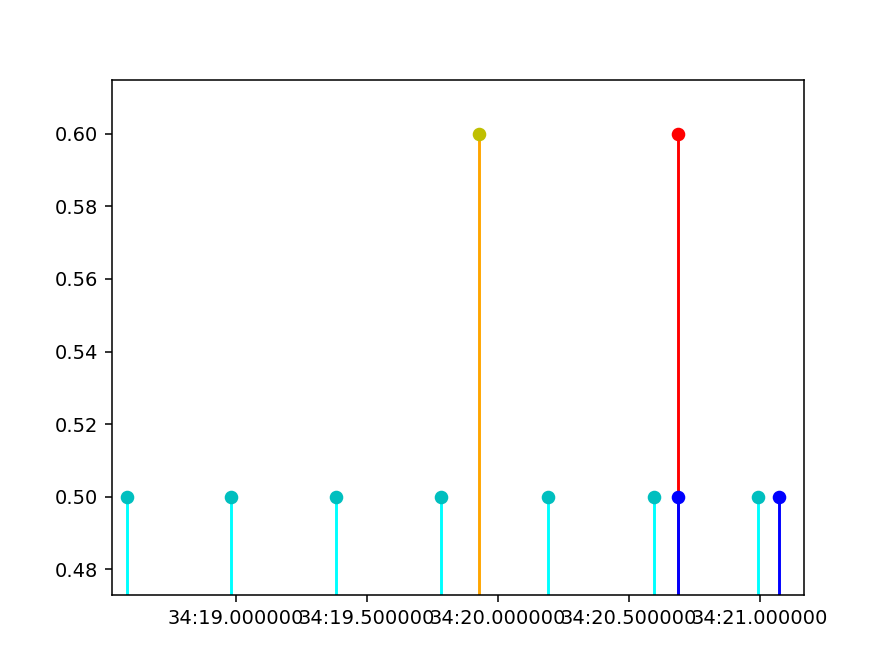

/tmp/ipykernel_41426/135994845.py:15: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax.stem(dio_com_red["Center_of_mass"], dio_com_red["Amp"],'red',markerfmt='ro') #markerfmt=' '
/tmp/ipykernel_41426/135994845.py:16: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax.stem(ica_com_red["Center_of_mass"], ica_com_red["Amp"],'orange',markerfmt='yo')
/tmp/ipykernel_41426/135994845.py:18: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax.stem(dio_com_blue["Center_of_mass"], dio_com_blue["Amp"],'blue',markerfmt='bo')
/tmp/ipykernel_41426/135994845.py:19: MatplotlibDeprecationWarning: Passing the linefmt parameter

In [13]:
# process the combined ica signals and get centre of mass for the aggregated signal from all eyes
ica_com_red,ica_com_blue = merge_ica_and_extract_com(red_ica_list,blue_ica_list)

# extract dio signal, time stamps, 
# process the dio signals and timestamps, and 
# get centre of mass for dio signals
dio_com_red, dio_com_blue = extract_dio_com(dio_file_path_dict)

visualise_ica_dio_coms(dio_com_red,ica_com_red,dio_com_blue,ica_com_blue)

In [26]:
ts_ica_red = pd.to_datetime(ica_com_red['Center_of_mass']).astype(int)/ 10**9
ts_dio_red = pd.to_datetime(dio_com_red['Center_of_mass']).astype(int)/ 10**9

ts_dio_blue = pd.to_datetime(dio_com_blue['Center_of_mass']).astype(int)/ 10**9
ts_ica_blue = pd.to_datetime(ica_com_blue['Center_of_mass']).astype(int)/ 10**9


ica_train_red, dio_train_red = trim_ts_before_first_overlap(ts_ica_red, ts_dio_red)
ica_train_blue, dio_train_blue = trim_ts_before_first_overlap(ts_ica_blue, ts_dio_blue)

# Train on red and test on blue
# pred_dio_blue,score = pred_dio_ts_from_ica_ts(ica_train_red,dio_train_red,ica_train_blue,dio_train_blue)
# print(score)
# print(dio_train_blue, pred_dio_blue)


# Train on partial red and test on partial red from later stages in the video
train_set_size = int(0.5 * len(ica_train_red))
pred_dio_red,score = pred_dio_ts_from_ica_ts(ica_train_red[:train_set_size],dio_train_red[:train_set_size],
                                              ica_train_red[train_set_size:],dio_train_red[train_set_size:])
print("R squared score of the ICA2DIO linear model: ",score)
# print(dio_train_red[train_set_size:], pred_dio_red)
error = dio_train_red[train_set_size:] - pred_dio_red
print("Min error in seconds on test set:", np.min(error))
print("Max error in seconds on test set:", np.max(error))

Regression coefficients of ICA to DIO ts model: [1.00002666]
R squared score of the ICA2DIO linear model:  0.9999999413969088
Min error in seconds on test set: -0.0052068233489990234
Max error in seconds on test set: 0.003557920455932617
